In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

/usr/local/lib/python3.6/dist-packages/backtesting/_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from GPyOpt.methods import BayesianOptimization

In [4]:
from data_io import load_data_by_ticker, get_call_data_for_given_ticker, display_all, display_shape, calls_amount

In [5]:
import matplotlib.font_manager as font_manager

font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'NanumGothic'

# Load data

In [6]:
df_input = pd.read_pickle('data/CALLS_FINAL.pkl')
display(df_input.head())
display(df_input.tail())

,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,8.0,목요일,28.0,24.5,32.1,0.0,1.7,50.0,67.3,14.1,...,55.0,NaN,6.0,2989.0,29310.0,21906.0,6624.0,"3,162,920","2,582,185","580,735"
2013-08-02,8.0,금요일,27.4,25.2,29.3,7.5,2.0,50.0,80.4,14.1,...,44.0,10.0,18.0,3389.0,30199.0,27457.0,8091.0,"3,162,920","2,582,185","580,735"
2013-08-03,8.0,토요일,28.9,26.7,32.6,0.1,3.7,230.0,72.3,14.0,...,48.0,17.0,19.0,3935.0,35965.0,32984.0,9601.0,"3,162,920","2,582,185","580,735"
2013-08-04,8.0,일요일,28.3,26.4,31.3,4.5,2.4,250.0,76.4,14.0,...,46.0,16.0,14.0,3682.0,36219.0,31856.0,10519.0,"3,162,920","2,582,185","580,735"
2013-08-05,8.0,월요일,27.7,26.4,30.1,7.0,3.2,230.0,78.9,14.0,...,28.0,8.0,12.0,2645.0,27561.0,19661.0,6318.0,"3,162,920","2,582,185","580,735"


,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2019-08-27,8.0,화요일,25.7,22.2,29.3,20.0,1.0,290.0,71.1,13.2,...,8.0,8.0,10.0,2359.0,10162.0,8168.0,3832.0,"11,190,709","3,943,856","7,246,854"
2019-08-28,8.0,수요일,26.1,23.6,30.2,0.0,1.9,270.0,66.2,13.2,...,21.0,10.0,5.0,2341.0,10491.0,8694.0,3974.0,"11,190,709","3,943,856","7,246,854"
2019-08-29,8.0,목요일,23.4,20.1,26.4,36.9,2.2,160.0,77.1,13.1,...,18.0,11.0,10.0,2612.0,14513.0,9406.0,4543.0,"11,190,709","3,943,856","7,246,854"
2019-08-30,8.0,금요일,22.6,19.5,27.0,0.2,2.4,200.0,66.3,13.1,...,25.0,10.0,8.0,2959.0,11548.0,12604.0,5118.0,"11,190,709","3,943,856","7,246,854"
2019-08-31,8.0,토요일,23.5,18.5,28.9,0.0,1.9,230.0,65.0,13.1,...,24.0,17.0,13.0,2876.0,13445.0,13597.0,5925.0,"11,190,709","3,943,856","7,246,854"


In [7]:
target_mtd = pd.read_csv('metadata/target_kospi.csv')
target_mtd['코드'] = target_mtd['코드'].apply(lambda x: str(int(x)).zfill(6))
target_mtd.columns = [x.replace('품목', '기업명') for x in target_mtd.columns]
target_mtd = target_mtd[['코드', '기업명']]
display(target_mtd.head())
display(target_mtd.tail())

,코드,기업명
0,009240,한샘
1,079430,현대리바트
2,021240,웅진코웨이
3,007310,오뚜기
4,017810,풀무원


,코드,기업명
20,080160,모두투어
21,044960,이글벳
22,086990,메디톡스
23,095700,제넥신
24,241590,화승엔터프라이즈


In [8]:
all_mtd = pd.read_pickle('history/kospi_download_result.pkl')
all_mtd

,종목코드,상장일,결과,기업명,업종
0,095570,2015-08-21,Naver,AJ네트웍스,산업용 기계 및 장비 임대업
1,068400,2012-07-27,Naver,AJ렌터카,운송장비 임대업
2,006840,1999-08-11,Naver,AK홀딩스,기타 금융업
3,027410,2014-05-19,Naver,BGF,기타 금융업
4,282330,2017-12-08,Naver,BGF리테일,종합 소매업
...,...,...,...,...,...
783,079980,2012-02-23,Naver,휴비스,화학섬유 제조업
784,005010,1973-06-29,Naver,휴스틸,1차 철강 제조업
785,069260,2002-10-07,Naver,휴켐스,기타 화학제품 제조업
786,000540,1974-12-05,Naver,흥국화재,보험업


# Functions

In [9]:
# load data
def load_data(ticker, visualize=False) : 

    stock_price = pd.read_pickle('data/kospi/%s.data' % ticker)
    stock_price.index = pd.to_datetime(stock_price.index)
    stock_price = stock_price.drop(['Adj Close'], axis=1)
    #stock_price = pd.DataFrame(stock_price[['Close']])
    #other_components = stock_price[['Open', 'High', 'Low', 'Volume']]
    stock_price

    # merge wihtout time lag
    df = stock_price.merge(df_input, how='inner', left_on=stock_price.index, right_on=df_input.index)
    df.index = df['key_0']
    df = df.drop(['key_0'], axis=1)

    # preprocess (remove object columns)
    for idx_day, day in enumerate(['월요일', '화요일', '수요일', '목요일', '금요일']) : 
        df['요일'] = df['요일'].apply(lambda x : idx_day if x==day else x)
    for column in df.select_dtypes('object').columns : 
        df[column] = df[column].apply(lambda x : x.replace(',', ''))
        df[column] = pd.to_numeric(df[column])

    #display(df)
    if visualize==True : 
        print(df.info())
    return df

In [10]:
def split_data(df, time_shift, visualize=False) : 

    # target y (future price)
    df['y'] = df['Close'].shift(time_shift)
    df = df[df['y'].notnull()]
    df = df[df.index <= datetime.datetime(2018,12,31)]

    # split train/test
    y = df['y'] # time-shifted future price
    x = df.drop(['y', 'Open', 'High', 'Low'], axis=1) # contains today's price 'Close', 'Volume'
    others = df[['Open', 'Close', 'High', 'Low', 'Volume']]
    x_columns = x.columns

    x_train = x[x.index < datetime.datetime(2017, 1, 1)].values
    x_valid = x[x.index >= datetime.datetime(2017, 1, 1)].values
    y_train = y[y.index < datetime.datetime(2017, 1, 1)].values
    y_valid = y[y.index >= datetime.datetime(2017, 1, 1)].values
    others_train = others[others.index < datetime.datetime(2017, 1, 1)]
    others_valid = others[others.index >= datetime.datetime(2017, 1, 1)]
    if visualize==True : 
        print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)
    return df, x, y, others, x_train, x_valid, y_train, y_valid, others_train, others_valid, x_columns

In [11]:
#model
def run_model(df, others, others_train, others_valid, x_train, y_train, x_valid, y_valid, time_shift, x_columns, visualize=False) : 
    model = lgbm(num_threads=num_threads)
    #model = xgb(nthread=num_threads)
    #model = cat(thread_count=num_threads, verbose=0)

    model.fit(x_train, y_train)

    y_train_hat = model.predict(x_train)
    y_valid_hat = model.predict(x_valid)

    if visualize==True:
        print(r2_score(y_train, y_train_hat), r2_score(y_valid, y_valid_hat))
        plt.figure(figsize=(50, 10))
        plt.plot(df.index, others['Close'], label='close')
        #plt.plot(df.index, pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True), label='%s after (close)' % (-time_shift))
        plt.plot(df.index, pd.concat([pd.Series(y_train_hat), pd.Series(y_valid_hat)], ignore_index=True), label='%s after (predicted)' % (-time_shift), alpha=0.6)
        plt.axvspan(df.index[0], df.index[len(y_train)], alpha=0.2, color='yellow', label='train')
        plt.title('%s(%s) : Stock price (%s days later)' % (company_name, 
                                                            ticker,
                                                           -time_shift))
        plt.legend()
        plt.show()
    
    data_valid = pd.DataFrame(x_valid, columns=x_columns)
    data_valid = data_valid.merge(others_valid, how='inner')
    yhat_valid = model.predict(data_valid.drop(['Open', 'High', 'Low'], axis=1))
    data_valid['time shifted'] = yhat_valid
    
    data_train = pd.DataFrame(x_train, columns=x_columns)
    data_train = data_train.merge(others_train, how='inner')
    yhat_train = model.predict(data_train.drop(['Open', 'High', 'Low'], axis=1))
    data_train['time shifted'] = yhat_train

    return data_train, data_valid

# 1. Get Company

In [81]:
# hyperparamter

#company_name = '웅진코웨이'
#ticker = all_mtd[all_mtd['기업명']==company_name]['종목코드'].values[0]

#idx_ticker = 7
#ticker = all_mtd['종목코드'].iloc[idx_ticker]
#company_name = all_mtd['기업명'].iloc[idx_ticker]

idx_ticker = 4
ticker = target_mtd['코드'][idx_ticker]
company_name = target_mtd['기업명'][idx_ticker]
num_threads = 24

# GpyOPt Test

In [82]:
domain = [{'name':'time_shift', 'type':'discrete', 'domain':(1,2,3,4,5)},
         {'name':'target_profit', 'type':'continuous', 'domain':(0.01, 0.2)},
         {'name':'days_to_hold', 'type':'discrete', 'domain':(2,3,4,5)}]

In [83]:
class Str(Strategy) :
    def init(self) :

        self.close = self.data['Close']
        self.time_shifted_price = self.data['time shifted']
        self.daycount = 0
        self.hold = False
        
    def next(self) :  
        
        if (self.close * (1+target_profit_global) < self.time_shifted_price) and (self.hold == False) :
            self.buy()
            self.hold = True
            self.daycount = 0
        
        self.daycount += 1
        
        if (self.daycount == days_to_hold_global) and (self.hold == True) :
            #if (self.close > self.time_shifted_price) : 
            #    self.sell()
            #    self.hold = False
            #else : 
            #    self.daycount = 0
            self.sell()
            self.hold = False

In [84]:
def func_to_optimize(given_domain) : 
    
    time_shift = int(given_domain[0][0])
    target_profit = given_domain[0][1]
    days_to_hold = int(given_domain[0][2])
    
    df = load_data(ticker)
    df, x, y, others, x_train, x_valid, y_train, y_valid, others_train, others_valid, x_columns = split_data(df, time_shift)
    data_train, data_valid = run_model(df, others, others_train, others_valid, x_train, y_train, x_valid, y_valid, time_shift, x_columns)
    
    global target_profit_global
    target_profit_global = target_profit
    global days_to_hold_global
    days_to_hold_global = days_to_hold
    
    bt = Backtest(data_train, Str, cash=10000000000, commission=0)
    result = bt.run()
    #bt.plot()

    value = result['Sharpe Ratio']
    if np.isnan(value) : 
        value = -2
    print(value)
    return value * (-1)

In [85]:
myBopt = BayesianOptimization(f=func_to_optimize, domain=domain)
myBopt.run_optimization(max_iter=50)

-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2


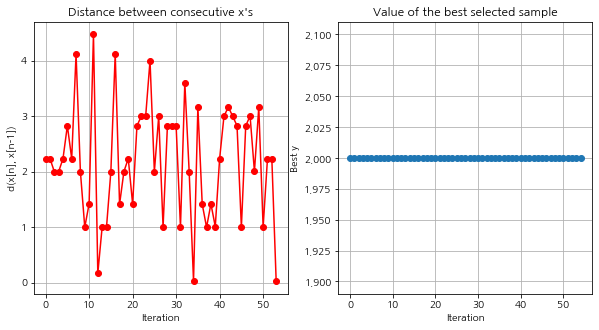

In [86]:
myBopt.plot_convergence()

In [87]:
print('Bst Hyperparameter : ', myBopt.x_opt)

Bst Hyperparameter :  [2.         0.19666911 2.        ]


In [88]:
print('Best Sharpe Ratio : ', -myBopt.fx_opt)

Best Sharpe Ratio :  -2.0


# 2. Hyperparameters

In [89]:
time_shift = int(myBopt.x_opt[0])
target_profit = myBopt.x_opt[1]
days_to_hold = int(myBopt.x_opt[2])

0.999739641046987 0.9346627031892649


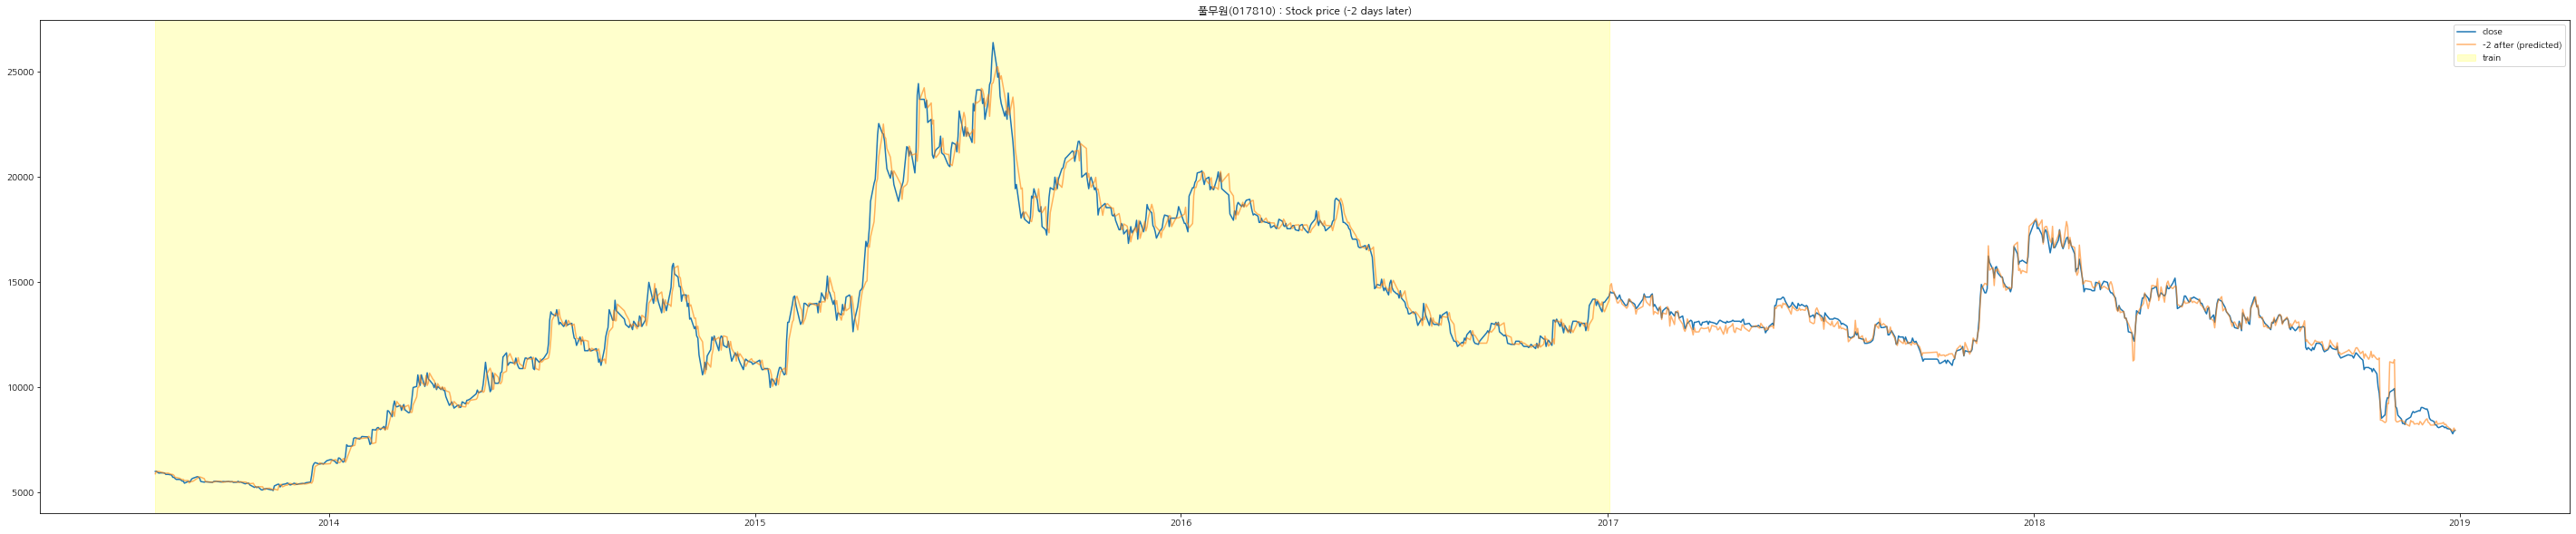

Sharpe Ratio :  -2


In [90]:
df = load_data(ticker)
df, x, y, others, x_train, x_valid, y_train, y_valid, others_train, others_valid, x_columns = split_data(df, time_shift)
data_train, data_valid = run_model(df, others, others_train, others_valid, x_train, y_train, x_valid, y_valid, time_shift, x_columns, visualize=True)

global target_profit_global
target_profit_global = target_profit
global days_to_hold_global
days_to_hold_global = days_to_hold

bt = Backtest(data_valid, Str, cash=10000000000, commission=0)
result = bt.run()
bt.plot()

value = result['Sharpe Ratio']
if np.isnan(value) : 
    value = -2
print('Sharpe Ratio : ', value)